In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/MyDrive/nlp'

/content/drive/.shortcut-targets-by-id/1yB3rFg9UAGv2aHwR7D2-NLQrTLAuwO7L/nlp


In [5]:
!pip install transformers==4.31.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


## Import các thư viện

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

## Load tập train và test

In [ ]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [ ]:
df = pd.concat([train,test],axis=0)
df_cleaned = df.dropna()

In [ ]:
df.shape

(11327, 2)

In [ ]:
df['Text'] = df['Text'].astype(str)

## Text Preprocessing

In [ ]:
df['num_words'] = df['Text'].apply(len)

In [ ]:
df.head()

Text  Emotion  num_words
0  There are tons of other paintings that I think...  neutral         59
1  Yet the dog had grown old and less capable , a...  sadness        169
2  When I get into the tube or the train without ...     fear         68
3  This last may be a source of considerable disq...     fear        173
4  She disliked the intimacy he showed towards so...    anger        151

In [ ]:
encoded_labels = {
    'joy': 0,
    'sadness': 1,
    'fear': 2,
    'anger': 3,
    'neutral': 4
}

## Train-Test Split

In [ ]:
train_data, test_data = train_test_split(df,test_size=0.3,random_state=101,shuffle=True,stratify=df.Emotion)

## Encoding emotion label

In [ ]:
train_data['Label'] = train_data.Emotion.map(encoded_labels)
test_data['Label'] = test_data.Emotion.map(encoded_labels)

In [ ]:
train_data.head()

Text  Emotion  num_words  \
3369  When we rearranged furniture in our flat and g...    anger         66   
5409                                           I will .  neutral          8   
151   I get angry when people disbelieve me or misun...    anger         58   
1442  It happened in a tram: some older people start...    anger        139   
1006           If a close relative's life is in danger.     fear         40   

      Label  
3369      3  
5409      4  
151       3  
1442      3  
1006      2

In [ ]:
test_data.head()

Text Emotion  num_words  \
1787  factor is coming back to TV! Guilty pleasure o...    fear         52   
6182  Night tweeps!! If you think the worst is over....    fear        100   
7524                               When a girl left me.   anger         20   
7592  When I slipped on a glazed frost road and a ca...    fear         67   
7465  In a conversation my boyfriend expressed defin...   anger        203   

      Label  
1787      2  
6182      2  
7524      3  
7592      2  
7465      3

## Load tokenizer class và pretrained BERT model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

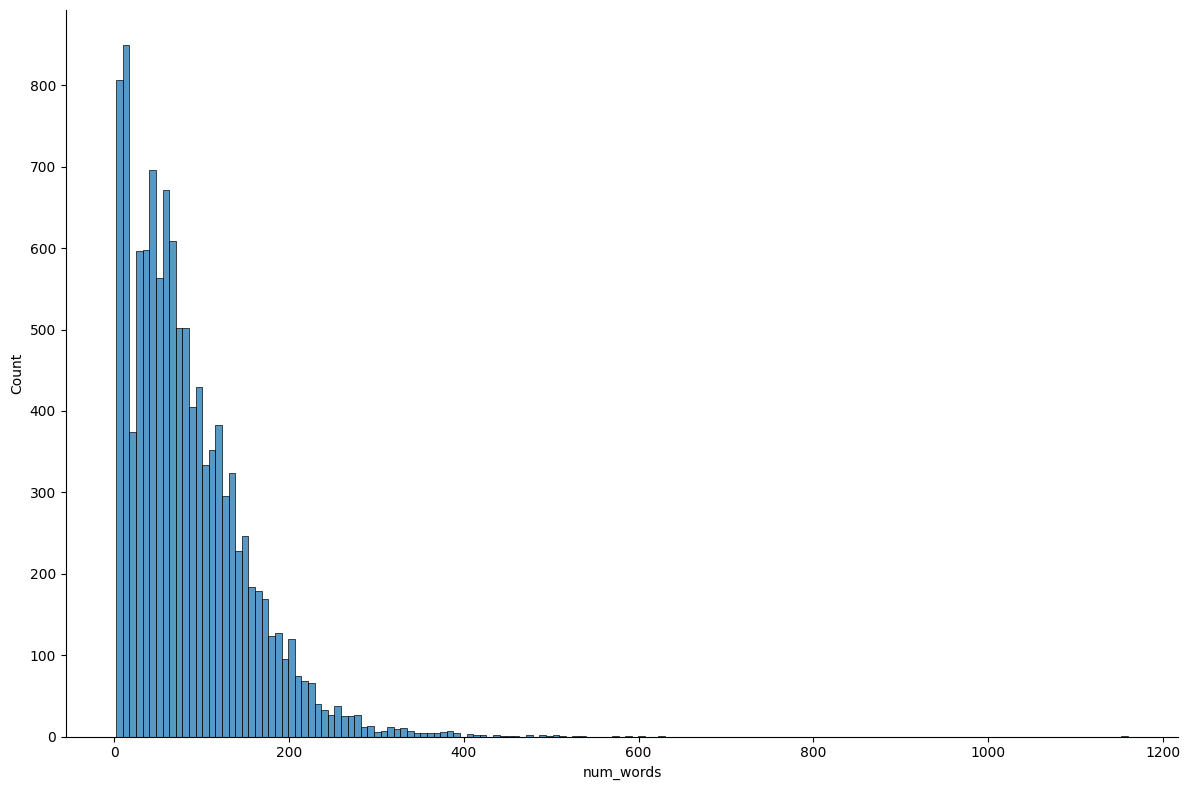

In [ ]:
sns.displot(df.num_words,height=8,aspect=1.5)

In [ ]:
max_len = 350

## Text Tokenization

In [ ]:
X_train = tokenizer(text=train_data.Text.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.Text.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

## Kiến trúc mô hình

In [ ]:
input_ids = Input(shape=(max_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_len,),name='attention_mask',dtype=tf.int32)

In [ ]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0]
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=5,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

## Tối ưu hóa bằng Adam và biên dịch mô hình

In [ ]:
from tensorflow.keras.optimizers import legacy

optimizer = legacy.Adam(
    learning_rate=5e-5,
    epsilon=1e-8,
    decay=0.01,
    clipnorm=1.0)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='balanced_accuracy')]
)

## Model summary + plot

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 350)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 350)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 350, 7                                       

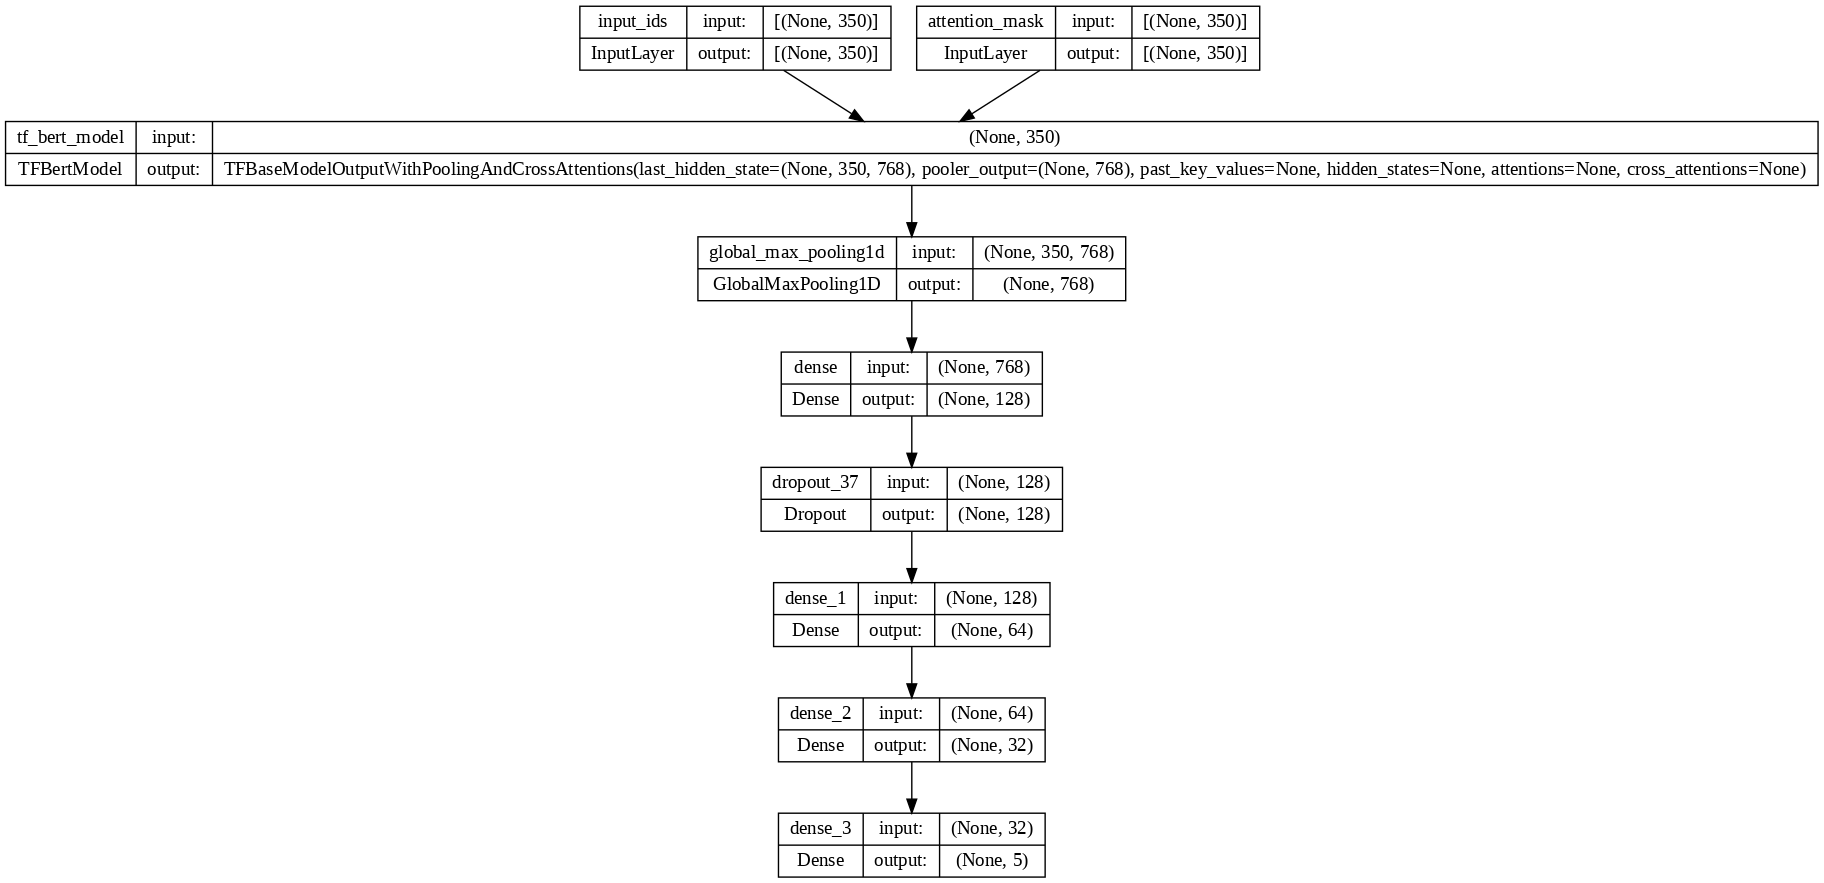

In [ ]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

## Train và fine tune pretrained BERT model

In [ ]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.Label),
             epochs=10,
             batch_size=16,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
             )

Epoch 1/10


496/496 [==============================] - 785s 2s/step - loss: 0.8726 - balanced_accuracy: 0.6794 - val_loss: 0.5746 - val_balanced_accuracy: 0.8073
Epoch 2/10
496/496 [==============================] - 703s 1s/step - loss: 0.4615 - balanced_accuracy: 0.8520 - val_loss: 0.5582 - val_balanced_accuracy: 0.8185
Epoch 3/10
496/496 [==============================] - 703s 1s/step - loss: 0.3548 - balanced_accuracy: 0.8899 - val_loss: 0.5515 - val_balanced_accuracy: 0.8247
Epoch 4/10
496/496 [==============================] - 756s 2s/step - loss: 0.2952 - balanced_accuracy: 0.9111 - val_loss: 0.5636 - val_balanced_accuracy: 0.8288
Epoch 5/10
496/496 [==============================] - 756s 2s/step - loss: 0.2523 - balanced_accuracy: 0.9228 - val_loss: 0.5798 - val_balanced_accuracy: 0.8238
Epoch 6/10
496/496 [==============================] - 756s 2s/step - loss: 0.2237 - balanced_accuracy: 0.9349 - val_loss: 0.5919 - val_balanced_accuracy: 0.8264
Epoch 7/10
496/496 [=========================

## Phân tích hiệu suất model

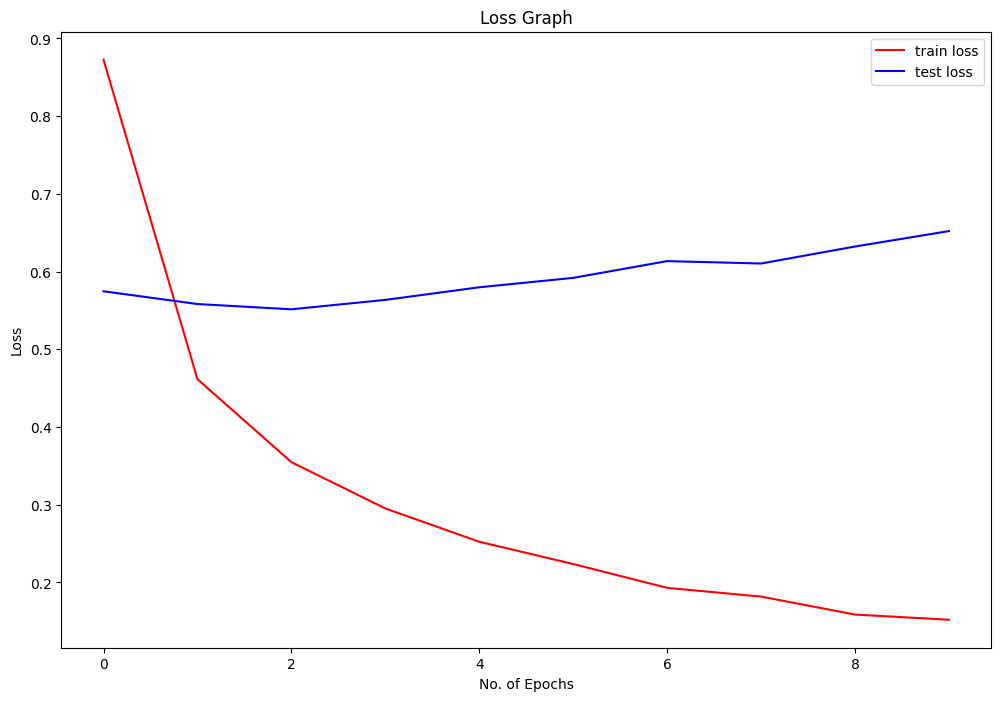

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

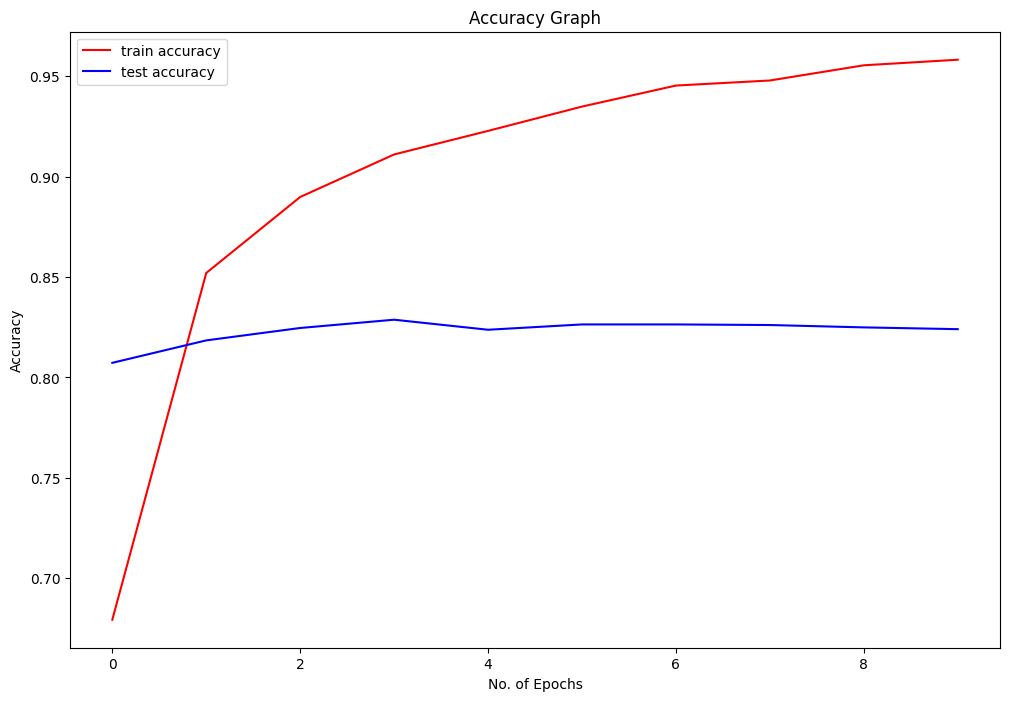

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Save model

In [ ]:
model.save("emotion_detector", save_format='tf')

## Evaluating model trên test dataset

In [ ]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

107/107 [==============================] - 89s 829ms/step - loss: 0.6521 - balanced_accuracy: 0.8241
Test Categorical Cross-Entropy Loss: 0.6521186232566833
Test Categorical Accuracy: 0.8240659236907959


In [ ]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

107/107 [==============================] - 88s 824ms/step
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       698
           1       0.79      0.83      0.81       695
           2       0.87      0.83      0.85       652
           3       0.82      0.75      0.79       678
           4       0.77      0.88      0.82       676

    accuracy                           0.82      3399
   macro avg       0.83      0.82      0.82      3399
weighted avg       0.83      0.82      0.82      3399



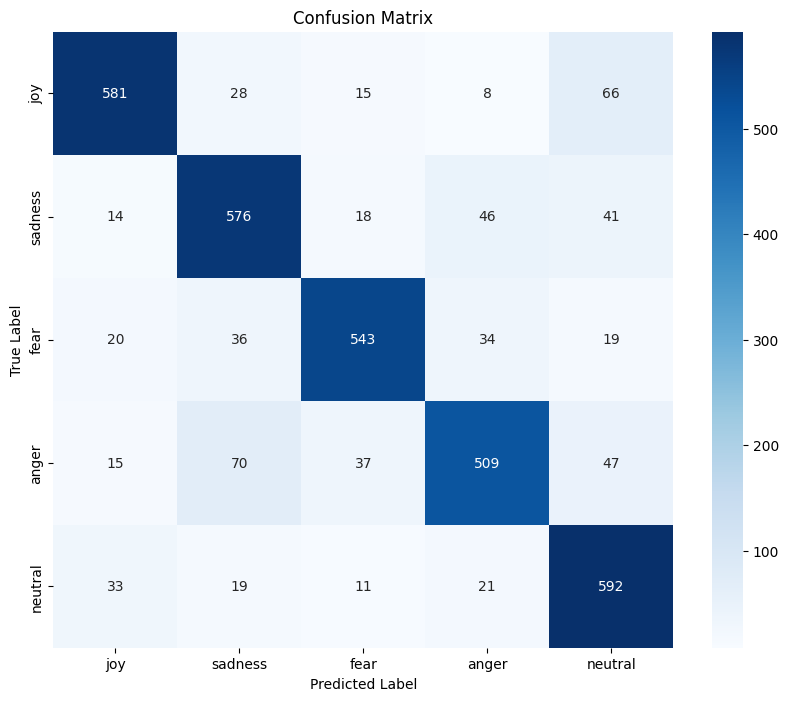

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(test_data['Label'], test_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoded_labels.keys(), yticklabels=encoded_labels.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Dự đoán input bất kì

In [3]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/nlp/models/emotion_detector', custom_objects={"TFBertModel": TFBertModel})

In [4]:
def predict_emotion(message):
    encoded_input = tokenizer.encode_plus(
        message,
        add_special_tokens=True,
        max_length=350,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='tf'
    )

    prediction = loaded_model.predict(
        {'input_ids': encoded_input['input_ids'], 'attention_mask': encoded_input['attention_mask']}
    )

    emotion_labels = ['joy', 'sadness', 'fear', 'anger', 'neutral']
    predicted_emotion = emotion_labels[prediction.argmax()]

    return predicted_emotion

message = "I feel really happy today"
predicted_emotion = predict_emotion(message)
print("Predicted emotion:", predicted_emotion)

1/1 [==============================] - 4s 4s/step
Predicted emotion: joy
